In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import stats
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
200 RuBisCOs with all core kinetic data measured


In [4]:
def make_PCA_data(df):
    # Here we are doing this on all the data, including all the RuBisCO isoforms
    vC_vals = df.vC.values
    Kc_vals = df.KC.values
    S_vals = df.S.values
    Kc_Ko_vals = Kc_vals / df.KO.values

    # Careful here: input data should have samples along rows, features along cols.
    data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
    return data

In [5]:
# Perform PCA on kin_df - the subset of the data for which we have all values.
data = make_PCA_data(kin_df)
log_data = np.log(data)
scaler = StandardScaler()
normed_log_data = scaler.fit_transform(log_data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pca_normed = PCA()
fitted_normed = pca_normed.fit(normed_log_data)

In [6]:
print('PCA of all data, no normalization')
pct_variance_explained = 100*fitted.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

print('PC1 = ', fitted.components_[0])

PCA of all data, no normalization
$1^{st}$ PC explains 73.5% of variance
$2^{nd}$ PC explains 16.4% of variance
PC1 0.081 *log(vC) + 0.54 *log(KC) + -0.4 *log(S) + 0.74 *log(KC/KO)
PC2 -0.64 *log(vC) + -0.57 *log(KC) + -0.45 *log(S) + 0.24 *log(KC/KO)
PC1 =  [ 0.08067305  0.53693013 -0.39917199  0.73882313]


In [7]:
print('PCA of all data, normalized in advance of PCA')
pct_variance_explained = 100*fitted_normed.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)


PCA of all data, normalized in advance of PCA
$1^{st}$ PC explains 60.2% of variance
$2^{nd}$ PC explains 28.5% of variance
PC1 0.081 *log(vC) + 0.54 *log(KC) + -0.4 *log(S) + 0.74 *log(KC/KO)
PC2 -0.64 *log(vC) + -0.57 *log(KC) + -0.45 *log(S) + 0.24 *log(KC/KO)


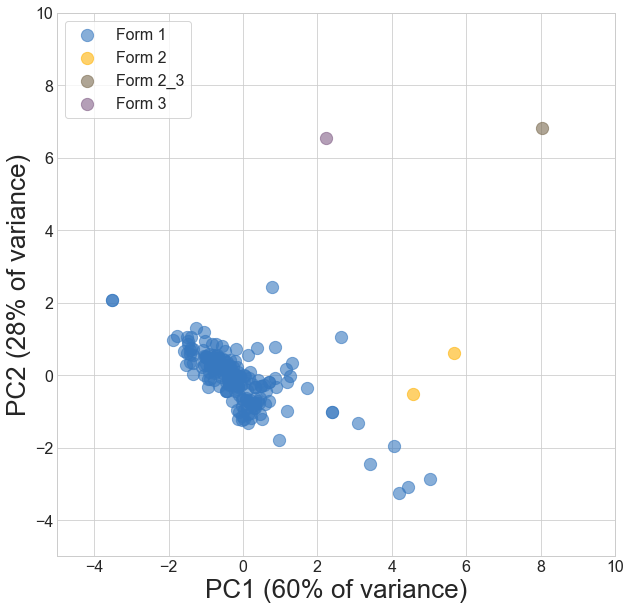

In [8]:
# Plot PCA of normalized data for all RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_normed.explained_variance_ratio_
transformed_normed = fitted_normed.transform(normed_log_data)
forms = sorted(kin_df.isoform.unique())
colormapping = dict((forms[i], named_colors[i]) for i in range(len(forms)))
colors = [colormapping[f] for f in kin_df.isoform]

for form in forms:
    idxs = np.where(kin_df.isoform == form)
    color = colormapping[form]
    l = 'Form %s' % form
    plt.scatter(transformed_normed[idxs, 0], transformed_normed[idxs, 1], s=150, c=color, label=l, alpha=0.6)

plt.xlabel('PC1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.savefig('figS4/figS4_normed_PCA_all_isoforms.png', dpi=600)

plt.show()

In [9]:
# Perform PCA on form I rubiscos for which we have all data.
F1s = kin_df[kin_df.isoform == '1']
F1data = make_PCA_data(F1s)

log_F1_data = np.log(F1data)
scaler = StandardScaler()
normed_logF1_data = scaler.fit_transform(log_F1_data)

pca = PCA(n_components=2)
fitted_F1 = pca.fit(log_F1_data)

pct_variance_explained = 100*fitted.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

pca_normed = PCA()
fitted_F1_normed = pca_normed.fit(normed_logF1_data)

$1^{st}$ PC explains 73.5% of variance
$2^{nd}$ PC explains 16.4% of variance
PC1 0.081 *log(vC) + 0.54 *log(KC) + -0.4 *log(S) + 0.74 *log(KC/KO)
PC2 -0.64 *log(vC) + -0.57 *log(KC) + -0.45 *log(S) + 0.24 *log(KC/KO)


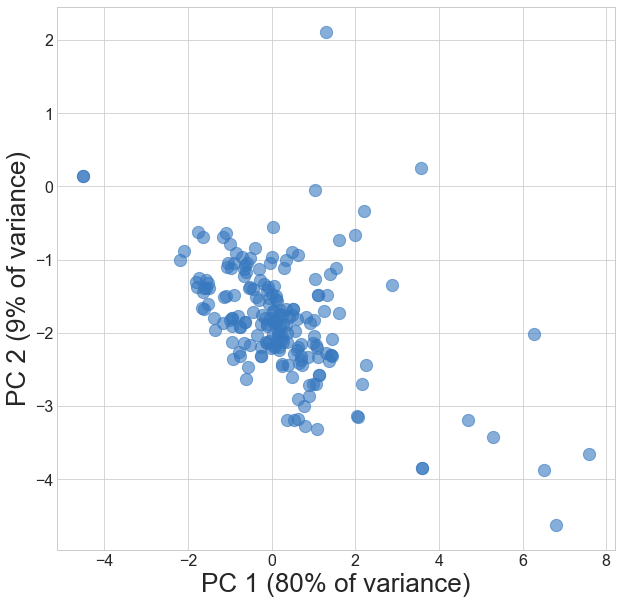

In [10]:
# Plot PCA of non-normalized data for FI RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_F1.explained_variance_ratio_
transformed = fitted_F1.transform(normed_logF1_data)

plt.scatter(transformed[:, 0], transformed[:, 1], s=150, c=named_colors[0], alpha=0.6)

plt.xlabel('PC 1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC 2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-5, 10)
#plt.ylim(-5, 10)

plt.savefig('figS4/figS4_PCA_F1.png', dpi=600)
plt.show()

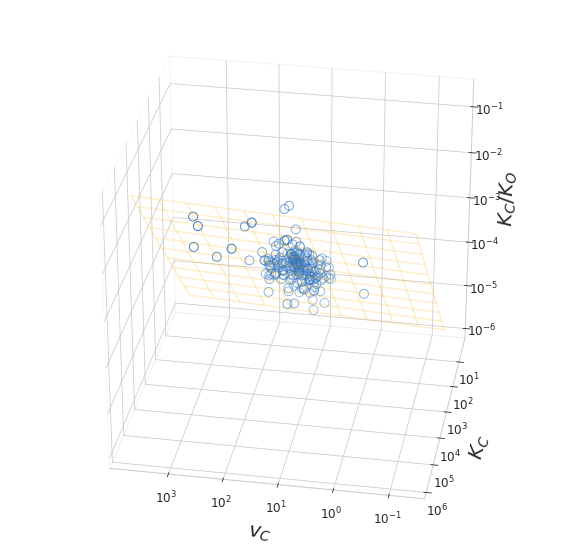

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

# Order of normed data is vC, KC, S, KC/KO
# Here x = vC, y = KC and z = KC/KO.
ax.scatter(log_F1_data[:, 0], log_F1_data[:, 1],  log_F1_data[:, 3],
           s=80, facecolors='none', edgecolors=named_colors[0])
    
ax.set_xlabel('$v_C$', fontsize=20, labelpad=12)
ax.set_ylabel('$K_C$', fontsize=20, labelpad=12)
ax.set_zlabel('$K_C/K_O$', fontsize=20, labelpad=12)

# Drop unplotted dim of the PCs
#pc1 = fitted_F1.components_[0]
#pc2 = fitted_F1.components_[1]
pc1 = fitted_F1_normed.components_[0]
pc2 = fitted_F1_normed.components_[1]
pc1_reordered = pc1[[0, 1, 3]]
pc2_reordered = pc2[[0, 1, 3]]
normal = np.cross(pc1_reordered, pc2_reordered)
d = -pc1_reordered.dot(normal)

# create x,y
domain = np.arange(-2.5, 2.5, 0.01)
xx, yy = np.meshgrid(domain, domain)
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
xx_shifted = xx + log_F1_data[:, 0].mean()
yy_shifted = yy + log_F1_data[:, 1].mean()
z_shifted = z + log_F1_data[:, 3].mean()

ax.plot_wireframe(xx_shifted, yy_shifted, z_shifted, alpha=0.2, rstride=50, cstride=50, color=named_colors[1])

# Set the viewing angle
ax.view_init(30, 100)

def _logscale(x, pos):
    return '$10^{%d}$' % x
formatter = FuncFormatter(_logscale)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.zaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(labelsize=12, pad=2)
ax.yaxis.set_tick_params(labelsize=12, pad=2)
ax.zaxis.set_tick_params(labelsize=12, pad=6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#ax.tick_params(pad=30)

#ax.set_ylim(-5, 5)
#ax.set_xlim(-5, 5)
#ax.set_zlim(-8, 8)
plt.show()

In [12]:
pct_variance_explained = 100*fitted_F1_normed.explained_variance_ratio_

print(pct_variance_explained)

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_F1_normed.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted_F1_normed.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

[70.93578117 12.7886144  11.30176674  4.97383769]
$1^{st}$ PC explains 70.9% of variance
$2^{nd}$ PC explains 12.8% of variance
PC1 0.47 *log(vC) + 0.52 *log(KC) + -0.48 *log(S) + 0.53 *log(KC/KO)
PC2 -0.66 *log(vC) + 0.49 *log(KC) + 0.37 *log(S) + 0.43 *log(KC/KO)


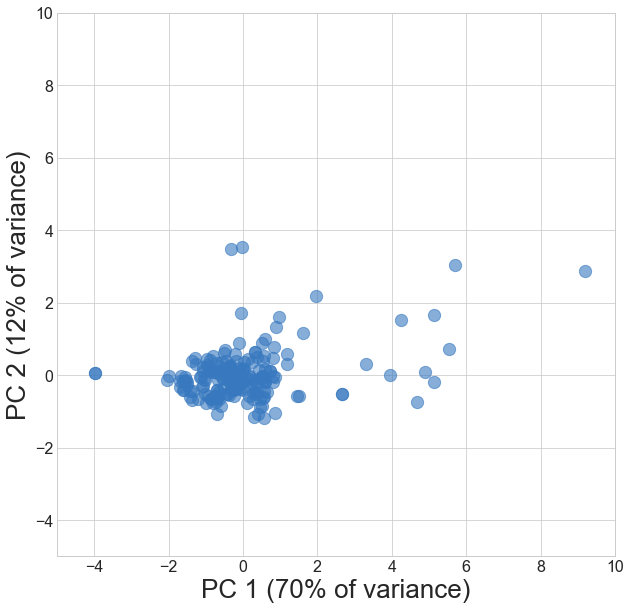

In [13]:
# Plot PCA of normalized data for FI RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_F1_normed.explained_variance_ratio_
transformed_normed = fitted_F1_normed.transform(normed_log_data)

plt.scatter(transformed_normed[:, 0], transformed_normed[:, 1], s=150, c=named_colors[0], alpha=0.6)

plt.xlabel('PC 1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC 2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.savefig('figS4/figS4_normed_PCA_F1.png', dpi=600)
plt.show()

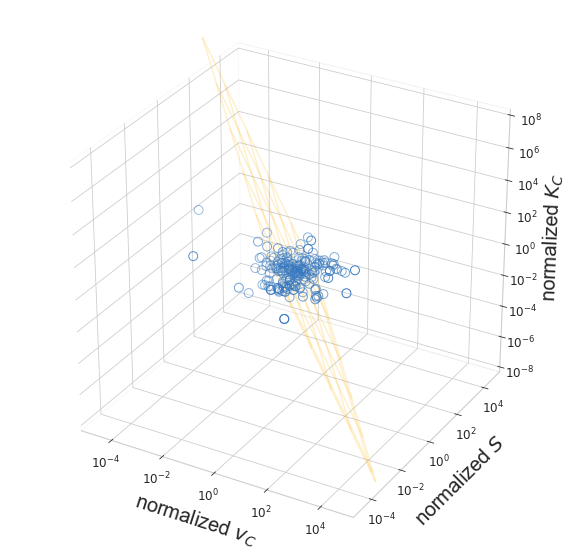

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

# Order of normed data is vC, KC, S, KC/KO
# Here x = vC, y = S and z = KC as in Savir 2010 figure 3.
ax.scatter(normed_logF1_data[:, 0], normed_logF1_data[:, 2],  normed_logF1_data[:, 1],
           s=80, facecolors='none', edgecolors=named_colors[0])
    
ax.set_xlabel('normalized $v_C$', fontsize=20, labelpad=12)
ax.set_ylabel('normalized $S$', fontsize=20, labelpad=12)
ax.set_zlabel('normalized $K_C$', fontsize=20, labelpad=12)

# Drop last dimension of the PCs
pc1 = fitted_F1_normed.components_[0]
pc2 = fitted_F1_normed.components_[1]
pc1_reordered = pc1[[0, 2, 1]]
pc2_reordered = pc2[[0, 2, 1]]
normal = np.cross(pc1_reordered, pc2_reordered)
d = -pc1_reordered.dot(normal)

# create x,y
domain = np.arange(-2.1, 2.1, 0.01)
xx, yy = np.meshgrid(domain, domain)
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
ax.plot_wireframe(xx, yy, z, alpha=0.2, rstride=80, cstride=80, color=named_colors[1])

# Set the viewing angle
ax.view_init(30, -60)

def _logscale(x, pos):
    return '$10^{%d}$' % x
formatter = FuncFormatter(_logscale)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.zaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(labelsize=12, pad=2)
ax.yaxis.set_tick_params(labelsize=12, pad=2)
ax.zaxis.set_tick_params(labelsize=12, pad=6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#ax.tick_params(pad=30)

ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)
ax.set_zlim(-8, 8)
plt.show()

In [15]:
# Perform PCA on Savir data
savir_data = make_PCA_data(savir_df)
mask = np.isfinite(savir_data).all(axis=1)
savir_all_data = savir_data[mask, :]

log_data = np.log(savir_all_data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pct_variance_explained = 100*fitted.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

print('PC1 = ', fitted.components_[0])

$1^{st}$ PC explains 91.4% of variance
$2^{nd}$ PC explains 5.6% of variance
PC1 0.34 *log(vC) + 0.69 *log(KC) + -0.25 *log(S) + 0.59 *log(KC/KO)
PC2 -0.047 *log(vC) + -0.46 *log(KC) + -0.86 *log(S) + 0.2 *log(KC/KO)
PC1 =  [ 0.34153395  0.68947651 -0.25301115  0.58648279]


In [16]:
# Perform PCA on Savir FI data
savir_FI = savir_df[savir_df.isoform == '1']
savir_FI_data = make_PCA_data(savir_FI)
mask = np.isfinite(savir_FI_data).all(axis=1)
savir_FI_all_data = savir_FI_data[mask, :]
print(savir_FI_all_data.shape)

log_data = np.log(savir_FI_all_data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pct_variance_explained = 100*fitted.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

print('PC1 = ', fitted.components_[0])

(15, 4)
$1^{st}$ PC explains 94.6% of variance
$2^{nd}$ PC explains 3.3% of variance
PC1 0.35 *log(vC) + 0.71 *log(KC) + -0.18 *log(S) + 0.58 *log(KC/KO)
PC2 0.0092 *log(vC) + -0.65 *log(KC) + -0.25 *log(S) + 0.72 *log(KC/KO)
PC1 =  [ 0.35346723  0.71219701 -0.17879864  0.57954066]


In [17]:
# Perform PCA on Savir FI data after normalization
savir_FI = savir_df[savir_df.isoform == '1']
savir_FI_data = make_PCA_data(savir_FI)
mask = np.isfinite(savir_FI_data).all(axis=1)
savir_FI_all_data = savir_FI_data[mask, :]
print(savir_FI_all_data.shape)

log_data = np.log(savir_FI_all_data)
scaler = StandardScaler()
normed_log_data = scaler.fit_transform(log_data)

pca_normed = PCA()
fitted_normed = pca_normed.fit(normed_log_data)

pct_variance_explained = 100*fitted_normed.explained_variance_ratio_

print(pct_variance_explained)

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_normed.components_[0].tolist())
print('PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)

complist = tuple(fitted_normed.components_[1].tolist())
print('PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist)



(15, 4)
[91.02110938  6.23818441  2.13998107  0.60072514]
$1^{st}$ PC explains 91.0% of variance
$2^{nd}$ PC explains 6.2% of variance
PC1 0.52 *log(vC) + 0.5 *log(KC) + -0.48 *log(S) + 0.5 *log(KC/KO)
PC2 -0.0022 *log(vC) + 0.48 *log(KC) + 0.82 *log(S) + 0.3 *log(KC/KO)
